In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, add,GlobalAveragePooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from keras.utils import plot_model
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from matplotlib import pyplot as plt
import pickle
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model

In [ ]:
def residual_block(input_tensor, filters, stride):
    if stride != 1 :
        shortcut = Conv2D(filters, kernel_size=(1, 1), padding='same', strides=stride)(input_tensor)
    else:
        shortcut = input_tensor

    x = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=stride)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = add([x, shortcut])
#     x = Activation('relu')(x)

    return x


def layer_n(input_image,b1,b2,b3,b4,b5): #b1 = 5, b2 = 2, b3 = 4, b4 = 2, b5 = 3

    # low level feature extractor

    def_out = Conv2D(16, kernel_size = (3,3), input_shape=(400, 400, 1))(input_image)
    def_out = BatchNormalization()(def_out)
    def_out = Activation('relu')(def_out)

    # High level feature extractor

    x = def_out

    for _ in range(b1):
        x = residual_block(x,16,1)

    for _ in range(b2):
        x = residual_block(x,32,2)

    for _ in range(b3):
        x = residual_block(x,32,1)

    for _ in range(b4):
        x = residual_block(x,64,2)

    for _ in range(b5):
        x = residual_block(x,64,1)

    x = AveragePooling2D(pool_size=(2, 2))(x)
#     x=GlobalAveragePooling2D()(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    return x

In [ ]:
inputs = Input(shape=(400, 400, 1))
result = layer_n(inputs, 3, 2, 2, 1, 3)
model = Model(inputs=inputs, outputs=result)

### Data Loading

In [ ]:

train_datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
)


train_gen = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/ga_detection_1/ga_det_train_test_val/train",
    target_size=(400, 400),  # Adjust as per your image size
    batch_size=32,
    class_mode='sparse',
    color_mode = 'grayscale',
    seed=42,
    shuffle=True
)

val_test_datagen = ImageDataGenerator()

val_gen = val_test_datagen.flow_from_directory(
    "/content/drive/MyDrive/ga_detection_1/ga_det_train_test_val/val",
    target_size=(400, 400),  # Adjust as per your image size
    batch_size=32,
    class_mode='sparse',
    color_mode = 'grayscale',
    seed=42,
    shuffle=False,
)

test_gen = val_test_datagen.flow_from_directory(
    "/content/drive/MyDrive/ga_detection_1/ga_det_train_test_val/test",
    target_size=(400, 400),  # Adjust as per your image size
    batch_size=32,
    class_mode='sparse',
    color_mode = 'grayscale',
    seed=42,
    shuffle=False,
)

Found 6771 images belonging to 2 classes.
Found 1693 images belonging to 2 classes.
Found 941 images belonging to 2 classes.


In [ ]:
unique_classes = np.unique(train_gen.classes)

# Calculate class weights
class_weights = compute_class_weight('balanced',classes = unique_classes,y=train_gen.classes)
class_weights_dict = dict(zip(unique_classes, class_weights))

In [ ]:
print(class_weights_dict)

{0: 1.518842530282638, 1: 0.7453764861294584}


In [ ]:
class_weights_dict

{0: 1.518842530282638, 1: 0.7453764861294584}

### Model Training

In [ ]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])
hist = model.fit(train_gen, epochs = 25,
#                  steps_per_epoch = 4872//32,
                 validation_data = val_gen,
#                  validation_steps = 1218//32, #previously 125//32
                 class_weight=class_weights_dict
                )


Epoch 1/25
212/212 [==============================] - 2138s 10s/step - loss: 0.3676 - accuracy: 0.9363 - val_loss: 0.9364 - val_accuracy: 0.7519
Epoch 2/25
212/212 [==============================] - 198s 934ms/step - loss: 0.1584 - accuracy: 0.9666 - val_loss: 0.2894 - val_accuracy: 0.9480
Epoch 3/25
212/212 [==============================] - 189s 889ms/step - loss: 0.1151 - accuracy: 0.9774 - val_loss: 0.1930 - val_accuracy: 0.9728
Epoch 4/25
212/212 [==============================] - 189s 891ms/step - loss: 0.0804 - accuracy: 0.9857 - val_loss: 0.2912 - val_accuracy: 0.9545
Epoch 5/25
212/212 [==============================] - 189s 890ms/step - loss: 0.0336 - accuracy: 0.9932 - val_loss: 0.0715 - val_accuracy: 0.9888
Epoch 6/25
212/212 [==============================] - 198s 934ms/step - loss: 0.0255 - accuracy: 0.9948 - val_loss: 0.1239 - val_accuracy: 0.9799
Epoch 7/25
212/212 [==============================] - 189s 889ms/step - loss: 0.0466 - accuracy: 0.9929 - val_loss: 0.1558 - 

### SAVE the model

In [ ]:
# saving model
model.save("/content/drive/MyDrive/ga_detection_1/ga_det_final_1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### SAVE the history

In [ ]:
# saving history 
with open('/content/drive/MyDrive/ga_detection_1/ga_det_final_1_history.pkl', 'wb') as file:
    pickle.dump(hist.history, file)

### LOAD the model

In [ ]:
# loading model and history
from keras.models import load_model

# Load the model
loaded_model = load_model("/content/drive/MyDrive/ga_detection_1/ga_det_final_1.h5")

### LOAD the history

In [ ]:
# Load the history
with open('/content/drive/MyDrive/ga_detection_1/ga_det_final_1_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

### Loss plot

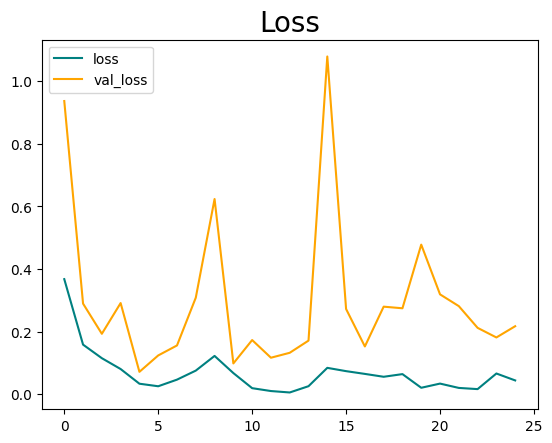

In [ ]:
plt.plot(loaded_history['loss'], color='teal', label='loss')
plt.plot(loaded_history['val_loss'], color='orange', label='val_loss')
plt.title('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Accuracy plot

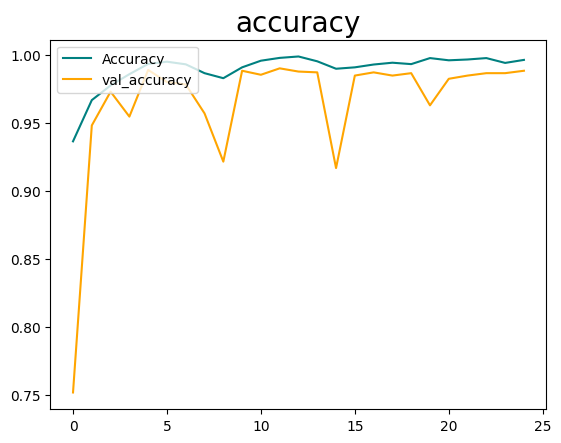

In [ ]:
# accuracy plot
plt.plot(loaded_history['accuracy'], color='teal', label='Accuracy')
plt.plot(loaded_history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming 'model' is your binary classification model and 'test_gen' is your test generator

# Get predicted probabilities for the positive class (class 1)
y_pred_probs = loaded_model.predict(test_gen)


y_pred = (y_pred_probs >= 0.2).astype(int)

# Get true labels from the test generator
y_true = test_gen.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional binary classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


30/30 [==============================] - 151s 5s/step
Confusion Matrix:
[[307   3]
 [  5 626]]
Accuracy: 0.9914984059511158
Precision: 0.9952305246422893
Recall: 0.9920760697305864
F1 Score: 0.9936507936507937


#### Confusion Matrix

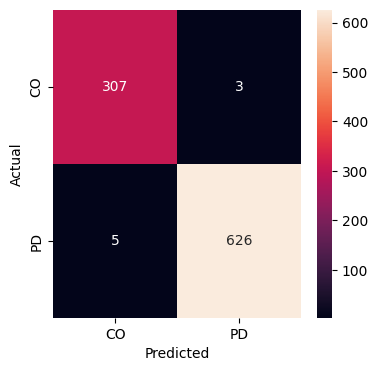

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(conf_matrix,fmt='d', annot=True,xticklabels=['CO','PD'], yticklabels=['CO','PD'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

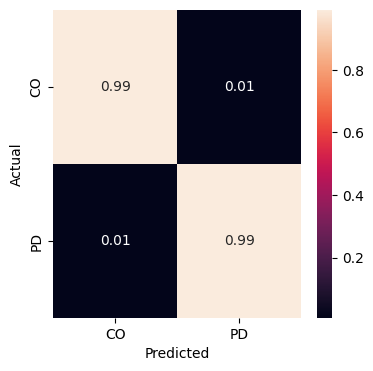

In [ ]:
import seaborn as sns
cm=conf_matrix
fig, ax = plt.subplots(figsize=(4,4))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn,fmt='.2f', annot=True,xticklabels=['CO','PD'], yticklabels=['CO','PD'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming 'model' is your binary classification model and 'test_gen' is your test generator

# Get predicted probabilities for the positive class (class 1)
y_pred_probs = loaded_model.predict(test_gen)


y_pred = (y_pred_probs >= 0.5).astype(int)

# Get true labels from the test generator
y_true = test_gen.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional binary classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


30/30 [==============================] - 285s 10s/step
Confusion Matrix:
[[307   3]
 [  8 623]]
Accuracy: 0.9883103081827843
Precision: 0.9952076677316294
Recall: 0.9873217115689382
F1 Score: 0.9912490055688147
